# Congressional Bill Cosponsorship Network Analysis

In [251]:
import pandas as pd
import numpy as np
import networkx as nx
import ipywidgets as widgets
import seaborn as sns

In [203]:
# create graph
df = pd.read_csv('data/edges.csv', names = ['from', 'to', 'weight'], index_col = False)
G = nx.from_pandas_edgelist(df, source = 'from', target = 'to', create_using = nx.DiGraph(), edge_attr='weight')

/var/folders/cr/g0jnhw1x2596k6jrbyw52m900000gn/T/ipykernel_13911/2477078385.py:2: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/edges.csv', names = ['from', 'to', 'weight'], index_col = False)


In [249]:
# load MOC data
moc = pd.read_csv('data/legislators.csv', dtype = {'district': 'Int64', 'thomas_id': 'object'})
moc = moc.drop(['full_name', 'middle_name', 'suffix', 'url', 'address', 'phone',
       'contact_form', 'rss_url', 'twitter', 'facebook', 'youtube',
       'youtube_id', 'opensecrets_id', 'lis_id',
       'fec_ids', 'cspan_id', 'govtrack_id', 'votesmart_id', 'ballotpedia_id',
       'washington_post_id', 'icpsr_id', 'wikipedia_id'], axis = 1)
moc.tail()

,Unnamed: 0,last_name,first_name,nickname,birthday,gender,type,state,district,senate_class,party,bioguide_id,thomas_id
12593,533,Finstad,Brad,NaN,1976-05-30,M,rep,MN,1,NaN,Republican,F000475,NaN
12594,534,Peltola,Mary,NaN,1973-08-31,F,rep,AK,0,NaN,Democrat,P000619,NaN
12595,535,Ryan,Patrick,NaN,1982-03-28,M,rep,NY,19,NaN,Democrat,R000579,NaN
12596,536,Sempolinski,Joseph,NaN,1982-02-10,M,rep,NY,23,NaN,Republican,S001219,NaN
12597,537,Yakym,Rudy,NaN,1984-02-24,M,rep,IN,2,NaN,Republican,Y000067,NaN


In [166]:
# get features
# takes ~1 hour running on my laptop

# get pagerank
rank = nx.pagerank(G)
features = pd.DataFrame(list(rank.keys()), columns = ['id'])
# features = pd.DataFrame(index = list(rank.keys()))
features['pagerank'] = rank.values()

# get clustering coefficient
cluster = nx.clustering(G)
features['clustering'] = cluster.values()

# get centrality
centrality = nx.degree_centrality(G)
features['centrality'] = centrality.values()

# get closeness
closeness = nx.closeness_centrality(G)
features['closeness'] = closeness.values()

# get betweenness
betweenness = nx.betweenness_centrality(G)
features['betweenness'] = betweenness.values()

features.head()

In [214]:
# combine network measures with MOC info

moc['thomas_id'] = moc.thomas_id.astype('float').astype('Int64')

df1 = features.merge(moc, how = 'left', left_on = 'id', right_on = 'bioguide_id')
df2 = features.merge(moc, how = 'left', left_on = 'id', right_on = 'thomas_id')
df = df1.combine_first(df2)

# fix columns and dtypes
df = df.drop(['Unnamed: 0'], axis = 1)
df = df.set_index('id')
df.index = df.index.astype('string')

df.head()

,pagerank,clustering,centrality,closeness,betweenness,nickname,full_name,birthday,gender,type,state,district,senate_class,party,bioguide_id,thomas_id
id,,,,,,,,,,,,,,,,
181,0.000315,0.788433,0.398574,0.312620,0.000034,NaN,NaN,1910-09-02,M,rep,KY,5,NaN,Republican,C000201,181
513,0.000253,0.864077,0.301158,0.297010,0.000012,NaN,NaN,1926-04-10,M,rep,NY,39,NaN,Republican,H000327,513
528,0.000417,0.572125,0.399168,0.316033,0.001627,NaN,NaN,1938-10-23,M,sen,PA,<NA>,1.0,Republican,H000456,528
570,0.000210,0.909239,0.238194,0.284927,0.000005,NaN,NaN,1932-10-17,M,rep,IN,11,NaN,Republican,H000906,570
656,0.000210,0.913392,0.238194,0.286336,0.000005,NaN,NaN,1925-07-11,M,rep,ME,1,NaN,Democrat,K000356,656


In [235]:
# get bipartisan score

# make + show progress bar
# because this takes like forever
progress_bar = widgets.IntProgress(
    min=0, max=len(G.nodes), description="calculating bipartisanship scores")
display(progress_bar)

# get same-party edge weight and total edge weight sums
for node1 in G.nodes:
    same_party_edges = 0
    # get same-party nodes
    for node2 in G[node1]:
        if df.loc[str(node1)].party == df.loc[str(node2)].party:
            same_party_edges += G[node1][node2]["weight"]
    # get total weights for node
    total_edge_weight = 0
    for nbr, datadict in G.adj[node1].items():
        total_edge_weight += datadict['weight']
    df.loc[str(node1), ['same_party_edges', 'total_edge_weight']] = [same_party_edges, total_edge_weight]
    
    progress_bar.value += 1
    
# calculate bipartisan_cosponsorship_score
df['bipartisan_cosponsorship_score'] = df['same_party_edges'] / df['total_edge_weight']
    
df.head()

IntProgress(value=0, description='calculating bipartisanship scores', max=3368)

NameError: name 'total_edge_weight' is not defined

In [263]:
# final cleaning
all_moc = df[df.party.isin(['Democrat', 'Republican'])]
all_moc['birthday'] = pd.to_datetime(all_moc.birthday)
modern_moc = all_moc[(all_moc['birthday'].year > '1950-01-01')]
#modern_moc = all_moc[all_moc.birthday.year > 1900]

AttributeError: 'Series' object has no attribute 'year'

In [ ]:
modern_moc.head()

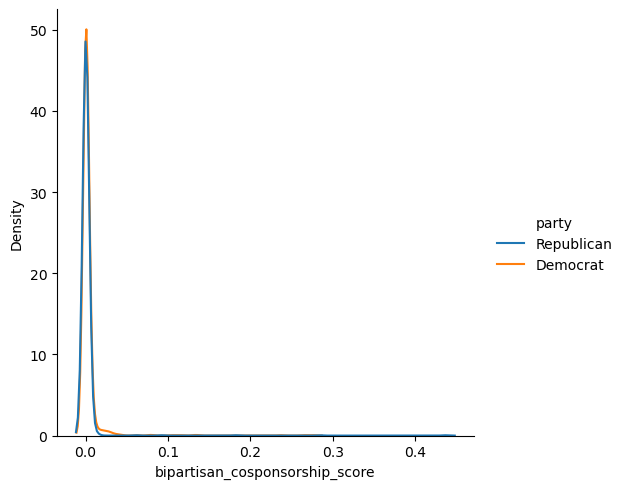

In [258]:
sns.displot(df, x = 'bipartisan_cosponsorship_score', kind = "kde", hue = 'party')

In [243]:
# top 10 MOCs by bipart score
df.sort_values('', ascending = False).head(10)

,pagerank,clustering,centrality,closeness,betweenness,nickname,full_name,birthday,gender,type,state,district,senate_class,party,bioguide_id,thomas_id,total_edge_weight,total_weight,same_party_edges,bipartisan_cosponsorship_score
id,,,,,,,,,,,,,,,,,,,,
181,0.000315,0.788433,0.398574,0.312620,0.000034,NaN,NaN,1910-09-02,M,rep,KY,5,NaN,Republican,C000201,181,31049.0,NaN,13553.0,0.436504
528,0.000417,0.572125,0.399168,0.316033,0.001627,NaN,NaN,1938-10-23,M,sen,PA,<NA>,1.0,Republican,H000456,528,108418.0,NaN,30767.0,0.283781
134,0.000589,0.489859,0.817939,0.422813,0.000944,NaN,NaN,1920-03-06,M,rep,CA,42,NaN,Democrat,B000918,134,1144696.0,NaN,315741.0,0.275830
229,0.000619,0.468973,0.858925,0.437511,0.001487,NaN,"John Conyers, Jr.",1929-05-16,M,rep,MI,13,NaN,Democrat,C000714,229,1899048.0,NaN,504306.0,0.265557
818,0.000400,0.672668,0.530443,0.342182,0.000115,NaN,NaN,1922-04-29,M,rep,MD,7,NaN,Democrat,M000826,818,602271.0,NaN,142946.0,0.237345
1221,0.000402,0.669351,0.533413,0.342858,0.000117,NaN,NaN,1925-03-12,M,rep,VA,2,NaN,Republican,W000406,1221,414065.0,NaN,75212.0,0.181643
1101,0.000620,0.468622,0.859519,0.437731,0.001489,Pete,Fortney Pete Stark,1931-11-11,M,rep,CA,13,NaN,Democrat,S000810,1101,3292809.0,NaN,447876.0,0.136016
1244,0.000415,0.654977,0.556579,0.348219,0.000140,NaN,NaN,1922-12-22,M,rep,TX,12,NaN,Democrat,W000763,1244,244765.0,NaN,32260.0,0.131800
944,0.000618,0.469778,0.856549,0.436631,0.001491,Charlie,Charles B. Rangel,1930-06-11,M,rep,NY,13,NaN,Democrat,R000053,944,4594631.0,NaN,530430.0,0.115446


In [242]:
# next: calculate bipartisanship score for each node
# then, visualize and analyze by party, state, type, etc.
# also look at most/least MOCs for other measures -- have to interpret them carefully
